# 패키지

In [ ]:
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import *
import keras


In [ ]:
tf.__version__

'2.4.1'

In [ ]:
%cd /content/drive/MyDrive/project2/2_Modeling/01_model_learning/

/content/drive/MyDrive/project2/2_Modeling/01_model_learning


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## DataFrame 전처리
- 여기서 이미지 사이즈 조절
- 여기서 model이름 설정
- path 조절
- train_test_split

In [ ]:
path_wrist = "../data2/2차 wrist"
path_middle = "../data2/2차 middle"
path_thumb = "../data2/2차 thumbs"
path_little = "../data2/2차 pinky"


In [ ]:
df = pd.read_csv("../../BA_total.csv")

In [ ]:
df.head()

,Unnamed: 0,index,No.,Group,등록번호,생년월일,성별,진료의,검사 시 나이,신장,체중,BMI,처방일자,시행일자,BA 1,BA 2,file_name,wrist_roi,middle_roi,thumb_roi,little_roi,BA,boneage,BA_z,gender
0,0,1,1,1568,8110925,2013-08-19,2,1,2.953425,88.9,11.3,14.3,2016-08-01,2016-08-01,3.25,3.25,1_F.jpg,1_F_w.jpg,1_F_m_M.jpg,1_F_t.jpg,1_F_p.jpg,3.250,39.0,-1.591783,0
1,1,2,2,440,5988227,2008-10-27,2,2,2.994521,95.9,13.5,14.7,2011-10-25,2011-10-25,1.75,1.75,2_F.jpg,2_F_w.jpg,2_F_m_M.jpg,2_F_t.jpg,2_F_p.jpg,1.750,21.0,-1.966701,0
2,2,3,3,1724,8292016,2013-08-08,2,1,3.010959,88.2,13.0,16.8,2016-08-11,2016-08-11,2.75,2.00,3_F.jpg,3_F_w.jpg,3_F_m_M.jpg,3_F_t.jpg,3_F_p.jpg,2.375,28.5,-1.810485,0
3,4,5,5,1264,7743478,2010-07-18,2,1,3.284932,90.8,14.0,17.0,2013-10-29,2013-10-29,3.75,4.25,5_F.jpg,5_F_w.jpg,5_F_m_M.jpg,5_F_t.jpg,5_F_p.jpg,4.000,48.0,-1.404324,0
4,5,6,6,1040,7579599,2011-04-06,2,1,3.312329,91.5,12.2,14.6,2013-12-11,2014-07-28,2.50,1.50,6_F.jpg,6_F_w.jpg,6_F_m_M.jpg,6_F_t.jpg,6_F_p.jpg,2.000,24.0,-1.904214,0


## 함수모음
- generator : input과 oupt을 만들어주는 함수
- plot_it : 학습후 모델 그래프를 만들고 저장해주는 함수
- mae_in_month : 정규화된 값을 학습시키기 때문에 개월로 변경한 mae계산해주는 함수

In [ ]:
ba_mean = df.boneage.mean()
ba_std = df.boneage.std()

In [ ]:
def generator(df,model,n):
    gender = np.array(df.gender)
    age = np.array(df.BA_z)
    wrist_in = []
    middle_in = []
    thumb_in = []
    little_in = []
    gender_in = []
    age_in = []
    
    error_list = []
    for i in range(len(df)):
        
        wrist_roi = df.loc[i,'wrist_roi']
        middle_roi = df.loc[i,'middle_roi']
        thumb_roi = df.loc[i,'thumb_roi']
        little_roi = df.loc[i,'little_roi']
 
    
        
        img_wrist = cv2.imread(path_wrist+'/'+wrist_roi)
        img_middle = cv2.imread(path_middle+'/'+middle_roi)
        img_thumb = cv2.imread(path_thumb+'/'+thumb_roi)
        img_little = cv2.imread(path_little+'/'+little_roi)
        

        try:
            img_wrist = cv2.resize(img_wrist, (224,224),cv2.INTER_AREA)
            img_middle = cv2.resize(img_middle, (50,250),cv2.INTER_AREA)
            img_thumb = cv2.resize(img_thumb, (50,250),cv2.INTER_AREA)
            img_little = cv2.resize(img_little, (50,250),cv2.INTER_AREA)
            
        except:
            continue

        wrist_in.append(img_wrist)
        middle_in.append(img_middle)
        thumb_in.append(img_thumb)
        little_in.append(img_little)
        
        gender_in.append(gender[i])
        age_in.append(age[i])
           
    wrist_in = np.array(wrist_in)
    middle_in = np.array(middle_in)
    thumb_in = np.array(thumb_in)
    little_in = np.array(little_in)
    gender_in = np.array(gender_in)
    age_in = np.array(age_in)
        
    if n==1:
        return age_in
        
    if n==2:
        return [gender_in,wrist_in,middle_in,thumb_in,little_in],age_in
        
    if n==3:
        return [wrist_in,middle_in,thumb_in,little_in,gender_in],age_in    

In [ ]:
def show(img):
    plt.figure(figsize=(15, 10))
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img, cmap = "gray")
    plt.show()

In [ ]:
# process시각화 및 손실함수

def plot_it(history):
    '''function to plot training and validation error'''
    fig, ax = plt.subplots( figsize=(20,10))
    ax.plot(history.history['mae_in_months'])
    ax.plot(history.history['val_mae_in_months'])
    plt.title('Model Error')
    plt.ylabel('error')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper right')
    ax.grid(color='black')
    plt.show()
    fig = plt.gcf()
    fig.savefig("../03_model_visualization/"+model_name+".jpg")
    plt.close(fig)

In [ ]:
from tensorflow.keras.metrics import mean_absolute_error

def mae_in_months(x_p, y_p):
    '''function to return mae in months'''
    return mean_absolute_error((ba_std*x_p + ba_mean), (ba_std*y_p + ba_mean)) 

## 모델 생성

In [ ]:
import sys
sys.path.insert(0,'../../03_Modeling/01_model_module')

In [ ]:
def mae_in_months(x_p, y_p):
    '''function to return mae in months'''
    return mean_absolute_error((ba_std*x_p + ba_mean), (ba_std*y_p + ba_mean))  

In [ ]:
def tjnet3():
  
    
    #원본이미지 모델 (mobilnet)
    #mob_model = tf.keras.applications.MobileNet(input_shape = (bimg_size, bimg_size, 3),
                                                   #include_top = False,
                                                                                  #weights = 'imagenet')
    #mob_model.trainable = True
    #model_2 = Sequential()
    #model_2.add(mob_model)
    #model_2.add(GlobalAveragePooling2D())
    #model_2.add(Dense(1024, activation = 'relu')) # 반으로줄임 

    # 손목roi 모델 (tj-net)

    i_input = Input(shape = (224,224,3))

    #block 1
    conv1 = ReLU()(Conv2D(32,3)(i_input))
    conv2 = ReLU()(Conv2D(32,3)(conv1))
    conv3 = ReLU()(Conv2D(64,3,padding='same')(conv2))# 필터통과후에 피쳐맵이 작아지므로 padding으로 유지
    x = Conv2D(64,1)(conv3)
    x = BatchNormalization()(x)

    se = GlobalAveragePooling2D()(x) # 각 피처맵상의 노드값들의 평균값을 뽑아냄 ,1차원 벡터로 만듬
    se = Dense(4,activation="relu")(se)
    se = Dense(64,activation="relu")(se)
    se = Reshape([1,1,64])(se)
    x = Multiply()([conv3,se])

    short = Conv2D(64,(1,1))(conv2)
    short = BatchNormalization()(short)

    x = ReLU()(add([x,short]))

    pool1 = MaxPool2D(pool_size=(2,2))(x)
    #block 2
    conv4 = ReLU()(Conv2D(60,3)(pool1))
    conv5 = ReLU()(Conv2D(192,3)(conv4))
    pool2 = MaxPool2D(pool_size=(2,2))(conv5)
    #block 3
    conv6 = ReLU()(Conv2D(512,3)(pool2))
    pool3 = MaxPool2D(pool_size=(2,2))(conv6)
    #block 4
    conv7 = ReLU()(Conv2D(512,3,padding='same')(pool3)) # 반으로 줄임
    pool4 = MaxPool2D(pool_size=(2,2))(conv7)
    i_output = Flatten()(pool4) # 완전 연결 네트워크에 연결하기 위해 1차원 배열로 변경

    i_model = Model(inputs = i_input, outputs = i_output)
    
    # 가운데손가락 roi 모델 (tj-net)

    i_input1 = Input(shape = (250,50,3))
    
    #block 1
    conv1 = ReLU()(Conv2D(32,3)(i_input1)) 
    conv2 = ReLU()(Conv2D(32,3)(conv1))
    conv3 = ReLU()(Conv2D(64,3,padding='same')(conv2)) 
    x = Conv2D(64,1)(conv3)
    x = BatchNormalization()(x)

    se = GlobalAveragePooling2D()(x)
    se = Dense(4,activation="relu")(se)
    se = Dense(64,activation="relu")(se)
    se = Reshape([1,1,64])(se)
    x = Multiply()([conv3,se])

    short = Conv2D(64,(1,1))(conv2)
    short = BatchNormalization()(short)

    x = ReLU()(add([x,short]))

    pool1 = MaxPool2D(pool_size=(2,2))(x)
    #block 2
    conv4 = ReLU()(Conv2D(60,3)(pool1))
    conv5 = ReLU()(Conv2D(192,3)(conv4))
    pool2 = MaxPool2D(pool_size=(2,2))(conv5)
    #block 3
    conv6 = ReLU()(Conv2D(256,3)(pool2))
    pool3 = MaxPool2D(pool_size=(2,2))(conv6)
    #block 4
    conv7 = ReLU()(Conv2D(512,3,padding='same')(pool3)) # 반으로 줄임
    pool4 = MaxPool2D(pool_size=(2,2))(conv7)
    i_output1 = Flatten()(pool4)

    i_model1 = Model(inputs = i_input1, outputs = i_output1)

    
    # 엄지손가락 roi 모델 (tj-net)

    i_input2 = Input(shape = (250,50,3))
    
    #block 1
    conv1 = ReLU()(Conv2D(32,3)(i_input2))
    conv2 = ReLU()(Conv2D(32,3)(conv1))
    conv3 = ReLU()(Conv2D(64,3,padding='same')(conv2))
    x = Conv2D(64,1)(conv3)
    x = BatchNormalization()(x)

    se = GlobalAveragePooling2D()(x)
    se = Dense(4,activation="relu")(se)    
    se = Dense(64,activation="relu")(se)   
    se = Reshape([1,1,64])(se)
    x = Multiply()([conv3,se])

    short = Conv2D(64,(1,1))(conv2)
    short = BatchNormalization()(short)

    x = ReLU()(add([x,short]))

    pool1 = MaxPool2D(pool_size=(2,2))(x)
    #block 2
    conv4 = ReLU()(Conv2D(60,3)(pool1))
    conv5 = ReLU()(Conv2D(192,3)(conv4))
    pool2 = MaxPool2D(pool_size=(2,2))(conv5)
    #block 3
    conv6 = ReLU()(Conv2D(256,3)(pool2))
    pool3 = MaxPool2D(pool_size=(2,2))(conv6)
    #block 4
    conv7 = ReLU()(Conv2D(512,3,padding='same')(pool3)) #반으로 줄임
    pool4 = MaxPool2D(pool_size=(2,2))(conv7)
    i_output2 = Flatten()(pool4)

    i_model2 = Model(inputs = i_input2, outputs = i_output2)

    
    # 새끼손가락 roi 모델 (tj-net)

    i_input3 = Input(shape = (250,50,3))
    
    #block 1
    conv1 = ReLU()(Conv2D(32,3)(i_input3))
    conv2 = ReLU()(Conv2D(32,3)(conv1))
    conv3 = ReLU()(Conv2D(64,3,padding='same')(conv2))
    x = Conv2D(64,1)(conv3)
    x = BatchNormalization()(x)

    se = GlobalAveragePooling2D()(x)
    se = Dense(4,activation="relu")(se)
    se = Dense(64,activation="relu")(se)
    se = Reshape([1,1,64])(se)
    x = Multiply()([conv3,se])

    short = Conv2D(64,(1,1))(conv2)
    short = BatchNormalization()(short)

    x = ReLU()(add([x,short]))

    pool1 = MaxPool2D(pool_size=(2,2))(x)
    #block 2
    conv4 = ReLU()(Conv2D(60,3)(pool1))
    conv5 = ReLU()(Conv2D(192,3)(conv4))
    pool2 = MaxPool2D(pool_size=(2,2))(conv5)
    #block 3
    conv6 = ReLU()(Conv2D(256,3)(pool2))
    pool3 = MaxPool2D(pool_size=(2,2))(conv6)
    #block 4
    conv7 = ReLU()(Conv2D(512,3,padding='same')(pool3)) # 이부분을 1024에서 512 로변경 
    pool4 = MaxPool2D(pool_size=(2,2))(conv7)
    i_output3 = Flatten()(pool4)

    i_model3 = Model(inputs = i_input3, outputs = i_output3)

    # gender 모델
    g_model = gender()

    #concat및 마무리
    con1 = concatenate([i_model.output,i_model1.output,i_model2.output,i_model3.output])
    dense1 = ReLU()(Dense(1024)(con1)) # dense1,2,3을 다 반으로 변경
    con2 = concatenate([dense1,g_model.output])
    dense2 = ReLU()(Dense(512)(con2))
    dense3 = ReLU()(Dense(256)(dense2))
    model_out = Dense(1,activation = "linear")(dense3)
    model = Model([i_model.input,i_model1.input,i_model2.input,i_model3.input,g_model.input],model_out)
    return model


In [ ]:
def gender(act='relu'):
    g_input = Input(shape = (1,))
    g_output = Dense(64,activation = act)(g_input)
    
    g_model = Model(inputs = g_input,outputs = g_output)
    return g_model

In [ ]:
model_name = "tjnet"
model_weight = model_name +"_weight.h5"

model = tjnet3()
model.save("../02_model_result/"+model_name+".h5")
model.compile(loss ='mse', optimizer= 'nadam', metrics = [mae_in_months] )

In [ ]:
model.input

[<KerasTensor: shape=(None, 224, 224, 3) dtype=float32 (created by layer 'input_1')>,
 <KerasTensor: shape=(None, 250, 50, 3) dtype=float32 (created by layer 'input_2')>,
 <KerasTensor: shape=(None, 250, 50, 3) dtype=float32 (created by layer 'input_3')>,
 <KerasTensor: shape=(None, 250, 50, 3) dtype=float32 (created by layer 'input_4')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'input_5')>]

In [ ]:
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 250, 50, 3)] 0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 250, 50, 3)] 0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 250, 50, 3)] 0                                            
____________________________________________________________________________________________

## train_val_set 만들기

In [ ]:
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(df, test_size = 0.2, random_state = 0)

train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

train_X,train_y = generator(train_df,model,3)
val_X,val_y = generator(val_df,model,3)

In [ ]:
len(train_df), len(val_df)

(976, 245)

In [ ]:
len(train_y),len(val_y)

(968, 242)

In [ ]:
train_y

## 초반에 loss 심한거 뺄려고 한번만 먼저 돌리기

In [ ]:
# model.load_weights("temp/"+model_weight)

model.fit(train_X,train_y,validation_data = (val_X,val_y),epochs = 1,batch_size=2)

484/484 [==============================] - 54s 57ms/step - loss: 23.6848 - mae_in_months: 76.3364 - val_loss: 42.2042 - val_mae_in_months: 306.7285


## 모델학습

Epoch 1/1000
484/484 [==============================] - 27s 55ms/step - loss: 7.0098e-04 - mae_in_months: 0.9505 - val_loss: 0.0831 - val_mae_in_months: 10.2196
Epoch 2/1000
484/484 [==============================] - 27s 55ms/step - loss: 3.4517e-04 - mae_in_months: 0.6823 - val_loss: 0.0811 - val_mae_in_months: 10.1100
Epoch 3/1000
484/484 [==============================] - 27s 55ms/step - loss: 3.0509e-04 - mae_in_months: 0.6404 - val_loss: 0.0821 - val_mae_in_months: 10.0813
Epoch 4/1000
484/484 [==============================] - 27s 55ms/step - loss: 2.7526e-04 - mae_in_months: 0.5987 - val_loss: 0.0813 - val_mae_in_months: 10.1017
Epoch 5/1000
484/484 [==============================] - 27s 55ms/step - loss: 4.1855e-04 - mae_in_months: 0.7280 - val_loss: 0.0811 - val_mae_in_months: 10.0782
Epoch 6/1000
484/484 [==============================] - 27s 55ms/step - loss: 3.8112e-04 - mae_in_months: 0.7206 - val_loss: 0.0820 - val_mae_in_months: 10.1558
Epoch 7/1000
484/484 [============

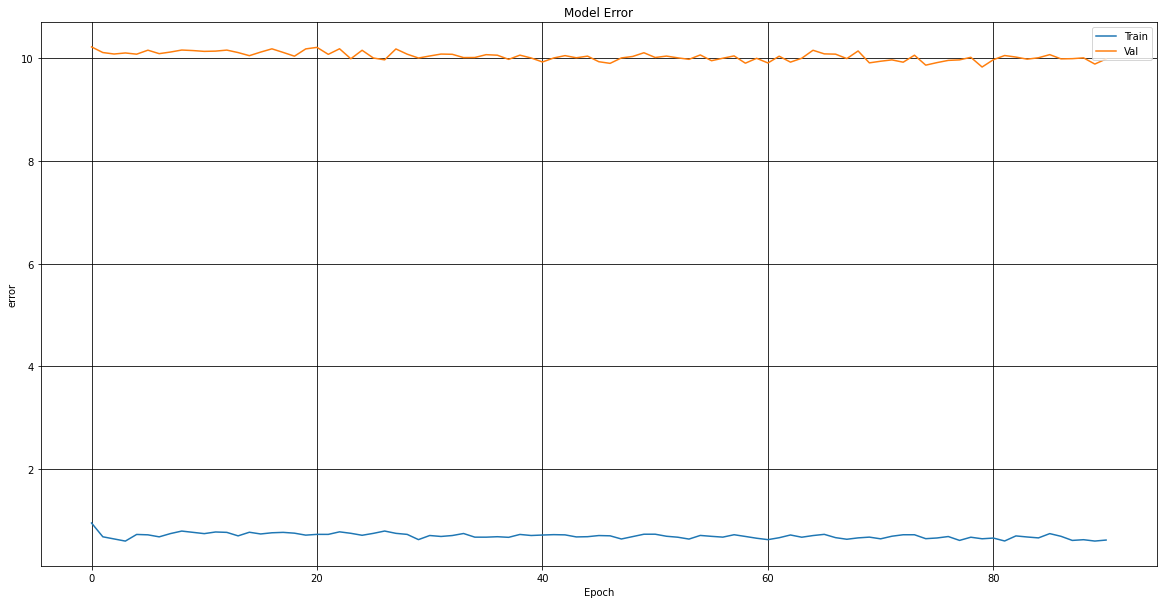

In [ ]:
# 모델 fit

epochs = 1000                                                    
#early stopping
early_stopping = EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience= 30, # 더이상 개선되지않은 것이 30 이상이면 종료
                              verbose=0, mode='auto')

# mc = ModelCheckpoint("temp/"+model_weight, monitor='val_loss', mode='min', save_best_only=True)
rLR = ReduceLROnPlateau(
    monitor='val_loss',  # 검증 손실을 기준으로 callback이 호출됩니다
    factor=0.5,          # callback 호출시 학습률을 1/2로 줄입니다
    patience=30,         # epoch 10 동안 개선되지 않으면 callback이 호출됩니다
)

callbacks = [early_stopping,rLR]


#fit model
history = model.fit(train_X,train_y,
                    validation_data = (val_X,val_y),
                    epochs = epochs,
                    callbacks= callbacks,
                    batch_size=2)
plot_it(history)

## 평가 및 저장

In [ ]:
pred = model.predict(val_X)*ba_std+ba_mean
mse, mae = model.evaluate(val_X,val_y)

from sklearn.metrics import r2_score
# r2 = r2_score(val_df.boneage,pred)

print(f"mae_year : {mae/12}, rmse : {mse/12}" )

8/8 [==============================] - 0s 56ms/step - loss: 0.0804 - mae_in_months: 9.9845
mae_year : 0.8320385615030924, rmse : 0.006701771169900894


In [ ]:
from sklearn.metrics import mean_absolute_error
v = val_y*ba_std+ba_mean
mean_absolute_error(np.round(pred),v)/12,mean_absolute_error(pred,v)/12

(0.8324227043709365, 0.8320386094011304)

In [ ]:

model.save_weights("../02_model_result/"+model_weight)